# Notebook 03: European Divergence Dashboard (CHF vs. EUR)
#
# **Pair:** Swiss Franc Futures (/6C) vs. Euro FX Futures (/6E)
# **Thesis:** Tracking the "European Divergence" trade.
#
# **Classic Correlation (Positive):**
# * **"Broad USD Move":** A strong/weak DXY (Dollar Index) causes both
#     the CHF and EUR to move together (inversely to the USD). The pair
#     is correlated, and the EUR/CHF cross is stable.
#
# **Decorrelation (The "Arbitrage"):**
# * **"EU-Specific Crisis":** A sovereign debt (e.g., Italy) or political
#     crisis sparks a "flight to quality" *within* Europe. Capital flees
#     the EUR (/6E falls) and flows *into* the CHF (/6C rises).
# * **"Policy Divergence":** The SNB (Swiss) turns hawkish to fight
#     inflation while the ECB (Euro) stays dovish to support growth,
#     driving the CHF up vs. the EUR.
#
# **Proxies Used:**
# * `/6C=F` (CHF Future) -> `FXF` (CHF ETF for clean price history)
# * `/6E=F` (EUR Future) -> `FXE` (EUR ETF for clean price history)
#
# **Causal Drivers (OSINT):**
# * `IRLTLT01ITM156N`: Italy 10-Yr Bond Yield.
# * `IRLTLT01DEM156N`: Germany 10-Yr Bond Yield.
#     * (Used to create the **BTP-Bund Spread**, our #1 EU Risk proxy).
# * `CPALTT01CHM656N`: Switzerland CPI (Monthly).
# * `CPHPTT01EZM656N`: Euro Area HICP (Monthly).
#     * (Used to create the **Inflation Differential**, our Policy proxy).

In [25]:
# Cell 1: Imports
#
# Import all necessary libraries for data, analysis, and visualization.
import yfinance as yf
from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import zscore
import requests
import os
import json
from datetime import datetime, timedelta

# Configure Pandas for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ Cell 1: Libraries imported successfully.")

✅ Cell 1: Libraries imported successfully.


In [26]:
# Cell 2: API & LLM Configuration
#
# Set up API keys, LLM endpoints, and asset tickers.

# --- FRED API Configuration ---
# ❗️ REQUIRES YOUR KEY: Get one from https://fred.stlouisfed.org/
os.environ.setdefault("FRED_API_KEY", "24a7e70f4690fbab7d2571d335107c68")

# --- LLM Configuration (Reused from your example) ---
os.environ.setdefault("LLM_BASE_URL", "http://127.0.0.1:11434") # Local Ollama server
os.environ.setdefault("LLM_MODEL", "qwen2.5:7b") # Your preferred model

def ask_llm(prompt: str, model=None, temperature=0.1):
    """Send a prompt to Ollama's CHAT endpoint and return the generated text."""
    model_to_use = model or os.getenv("LLM_MODEL")
    url_to_use = f"{os.getenv('LLM_BASE_URL')}/api/chat"

    chat_payload = {
        "model": model_to_use,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {"temperature": temperature},
        "stream": False
    }
    
    try:
        response = requests.post(url_to_use, json=chat_payload)
        response.raise_for_status()
        json_response = response.json()
        if "message" in json_response and "content" in json_response["message"]:
            return json_response["message"]["content"]
        else:
            return "Error: Unexpected response structure from /api/chat"
    except Exception as e:
        print(f"❌ LLM Error: {e}")
        return f"Error connecting to LLM at {url_to_use}. Is Ollama running?"

# --- Asset & Driver Configuration ---
YFINANCE_TICKERS = ["FXF", "FXE"]
FRED_SERIES_IDS = [
    "IRLTLT01ITM156N", # Italy 10Y Yield
    "IRLTLT01DEM156N", # Germany 10Y Yield
    "CPALTT01CHM657N", # Switzerland CPI
    "CP0000EZ19M086NEST"  # Euro Area HICP
]

# --- Date Range Configuration ---
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=5 * 365) # 5 years of data

print("✅ Cell 2: Configuration loaded.")
print(f"Fetching data for: {YFINANCE_TICKERS} and {FRED_SERIES_IDS}")

✅ Cell 2: Configuration loaded.
Fetching data for: ['FXF', 'FXE'] and ['IRLTLT01ITM156N', 'IRLTLT01DEM156N', 'CPALTT01CHM657N', 'CP0000EZ19M086NEST']


In [27]:
# Cell 3: Data Collection - yfinance
#
# Fetch historical price data for our ETF proxies (FXF, FXE).
try:
    print(f"Fetching yfinance data from {START_DATE.date()} to {END_DATE.date()}...")

    yf_data = yf.download(YFINANCE_TICKERS, start=START_DATE, end=END_DATE)

    # Select the 'Close' column for each ticker
    df_yf = yf_data.xs('Close', level=0, axis=1).copy()
    df_yf.index = pd.to_datetime(df_yf.index)

    print("✅ Cell 3: yfinance data fetched successfully.")
    print(df_yf.tail())
except Exception as e:
    print(f"❌ Cell 3: yfinance data fetch failed: {e}")

Fetching yfinance data from 2020-11-04 to 2025-11-03...


/tmp/ipykernel_732383/2504149046.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf_data = yf.download(YFINANCE_TICKERS, start=START_DATE, end=END_DATE)
[                       0%                       ]

[*********************100%***********************]  2 of 2 completed

✅ Cell 3: yfinance data fetched successfully.
Ticker             FXE         FXF
Date                              
2025-10-27  107.519997  111.279999
2025-10-28  107.540001  111.580002
2025-10-29  107.050003  110.570000
2025-10-30  106.720001  110.309998
2025-10-31  106.370003  109.959999


In [28]:
# Cell 4: Data Collection - FRED
#
# Fetch historical macro data for our causal drivers from FRED.
# Note: CPI data is monthly, so ffill() will be critical.
try:
    print("Fetching FRED data...")
    fred = Fred(api_key=os.getenv("FRED_API_KEY"))
    
    df_fred_list = []
    for series_id in FRED_SERIES_IDS:
        series = fred.get_series(series_id, START_DATE, END_DATE)
        df_fred_list.append(series.rename(series_id))
        
    df_fred = pd.concat(df_fred_list, axis=1)
    df_fred.index = pd.to_datetime(df_fred.index)

    print("✅ Cell 4: FRED data fetched successfully.")
    print(df_fred.tail())

except Exception as e:
    print(f"❌ Cell 4: FRED data fetch failed. Is your API key correct?")
    print(e)

Fetching FRED data...


✅ Cell 4: FRED data fetched successfully.
            IRLTLT01ITM156N  IRLTLT01DEM156N  CPALTT01CHM657N  CP0000EZ19M086NEST
2025-05-01            3.629         2.562857              NaN              128.65
2025-06-01            3.501         2.519048              NaN              129.04
2025-07-01            3.537         2.631304              NaN              129.04
2025-08-01            3.539         2.673333              NaN              129.24
2025-09-01            3.559         2.693333              NaN              129.37


In [29]:
# Cell 5: Data Consolidation & Cleaning
#
# Merge the yfinance (market) and FRED (macro) data into a single DataFrame.
# Use 'outer' join to keep all dates, then 'ffill' to fill monthly data.
try:
    df = pd.merge(df_yf, df_fred, left_index=True, right_index=True, how='outer')
    
    # Forward-fill missing values (CRITICAL for monthly CPI data)
    df = df.ffill()
    
    # Drop any initial NaNs from the start of the dataset
    df = df.dropna()
    
    print("✅ Cell 5: Data consolidated and cleaned.")
    print(df.tail())
    
except Exception as e:
    print(f"❌ Cell 5: Data merge failed: {e}")

✅ Cell 5: Data consolidated and cleaned.
                   FXE         FXF  IRLTLT01ITM156N  IRLTLT01DEM156N  CPALTT01CHM657N  CP0000EZ19M086NEST
2025-10-27  107.519997  111.279999            3.559         2.693333         0.031103              129.37
2025-10-28  107.540001  111.580002            3.559         2.693333         0.031103              129.37
2025-10-29  107.050003  110.570000            3.559         2.693333         0.031103              129.37
2025-10-30  106.720001  110.309998            3.559         2.693333         0.031103              129.37
2025-10-31  106.370003  109.959999            3.559         2.693333         0.031103              129.37


In [30]:
# Cell 6: Feature Engineering - Normalization (Z-Scores)
#
# Normalize all data to compare them on the same scale.
try:
    df_normalized = pd.DataFrame(index=df.index)
    # Apply zscore, handling potential NaNs from different start dates
    for col in df.columns:
        df_normalized[col] = zscore(df[col].dropna())
    
    # Re-fill any NaNs created by z-scoring (if any)
    df_normalized = df_normalized.ffill().dropna()
    
    print("✅ Cell 6: Data normalized (Z-Scores).")
    print(df_normalized.describe()) # Describe shows mean ~0, std ~1
    
except Exception as e:
    print(f"❌ Cell 6: Normalization failed: {e}")

✅ Cell 6: Data normalized (Z-Scores).
                FXE           FXF  IRLTLT01ITM156N  IRLTLT01DEM156N  CPALTT01CHM657N  CP0000EZ19M086NEST
count  1.273000e+03  1.273000e+03     1.273000e+03      1273.000000      1273.000000        1.273000e+03
mean   1.562859e-16 -1.027022e-15    -2.232656e-16         0.000000         0.000000        1.428900e-15
std    1.000393e+00  1.000393e+00     1.000393e+00         1.000393         1.000393        1.000393e+00
min   -2.524127e+00 -2.387913e+00    -1.784357e+00        -1.744354        -1.659457       -1.874940e+00
25%   -6.630039e-01 -4.996154e-01    -8.967692e-01        -1.118729        -0.396220       -1.004220e+00
50%   -1.988260e-01 -1.466111e-01     3.988458e-01         0.544225        -0.396220        4.260701e-01
75%    9.320552e-01  4.435074e-01     7.674574e-01         0.781050         0.429051        8.551570e-01
max    1.908342e+00  2.663725e+00     1.359426e+00         1.057468         2.838656        1.207711e+00


In [31]:
# Cell 7: Feature Engineering - Ratios & Spreads
#
# Calculate the key ratios and spreads that define our thesis.
#
# * Ratio: The price of CHF (FXF) divided by the price of EUR (FXE).
#     A RISING ratio signals CHF is outperforming EUR (our thesis).
# * Causal Spreads: The *drivers* of the decorrelation.

try:
    # 1. Price Ratio (The Core Signal)
    df['CHF_EUR_Ratio'] = df['FXF'] / df['FXE']
    
    # 2. Normalized Price Spread (Divergence Magnitude)
    df['CHF_EUR_Spread_Norm'] = df_normalized['FXF'] - df_normalized['FXE']
    
    # 3. Causal Spread 1: EU Risk (BTP-Bund Spread)
    # (Italy 10Y Yield - Germany 10Y Yield)
    df['EU_Risk_Spread'] = df['IRLTLT01ITM156N'] - df['IRLTLT01DEM156N']
    
    # 4. Causal Spread 2: Policy Divergence (Inflation Differential)
    # (Swiss CPI - Euro Area CPI)
    df['Inflation_Differential'] = df['CPALTT01CHM657N'] - df['CP0000EZ19M086NEST']

    print("✅ Cell 7: Ratios and Spreads calculated.")
    print(df[['CHF_EUR_Ratio', 'EU_Risk_Spread', 'Inflation_Differential']].tail())
    
except Exception as e:
    print(f"❌ Cell 7: Ratio/Spread calculation failed: {e}")

✅ Cell 7: Ratios and Spreads calculated.
            CHF_EUR_Ratio  EU_Risk_Spread  Inflation_Differential
2025-10-27       1.034970        0.865667             -129.338897
2025-10-28       1.037567        0.865667             -129.338897
2025-10-29       1.032882        0.865667             -129.338897
2025-10-30       1.033639        0.865667             -129.338897
2025-10-31       1.033750        0.865667             -129.338897


In [32]:
# Cell 8: Feature Engineering - Rolling Correlations
#
# Calculate the 30-day and 90-day rolling correlations between
# the *daily returns* of FXF and FXE.
# * Correlation near 1.0 = "Broad USD Move" regime.
# * Correlation falling/negative = "Divergence" regime.

try:
    # First, get daily percentage returns
    df['FXF_pct'] = df['FXF'].pct_change()
    df['FXE_pct'] = df['FXE'].pct_change()
    
    # Calculate rolling correlations
    df['Corr_30D'] = df['FXF_pct'].rolling(window=30).corr(df['FXE_pct'])
    df['Corr_90D'] = df['FXF_pct'].rolling(window=90).corr(df['FXE_pct'])

    print("✅ Cell 8: Rolling correlations calculated.")
    print(df[['Corr_30D', 'Corr_90D']].tail())

except Exception as e:
    print(f"❌ Cell 8: Correlation calculation failed: {e}")

✅ Cell 8: Rolling correlations calculated.
            Corr_30D  Corr_90D
2025-10-27  0.935829  0.899863
2025-10-28  0.916176  0.897198
2025-10-29  0.905785  0.898952
2025-10-30  0.906432  0.902424
2025-10-31  0.906471  0.902260


Plotting Cell 9: Core Thesis...


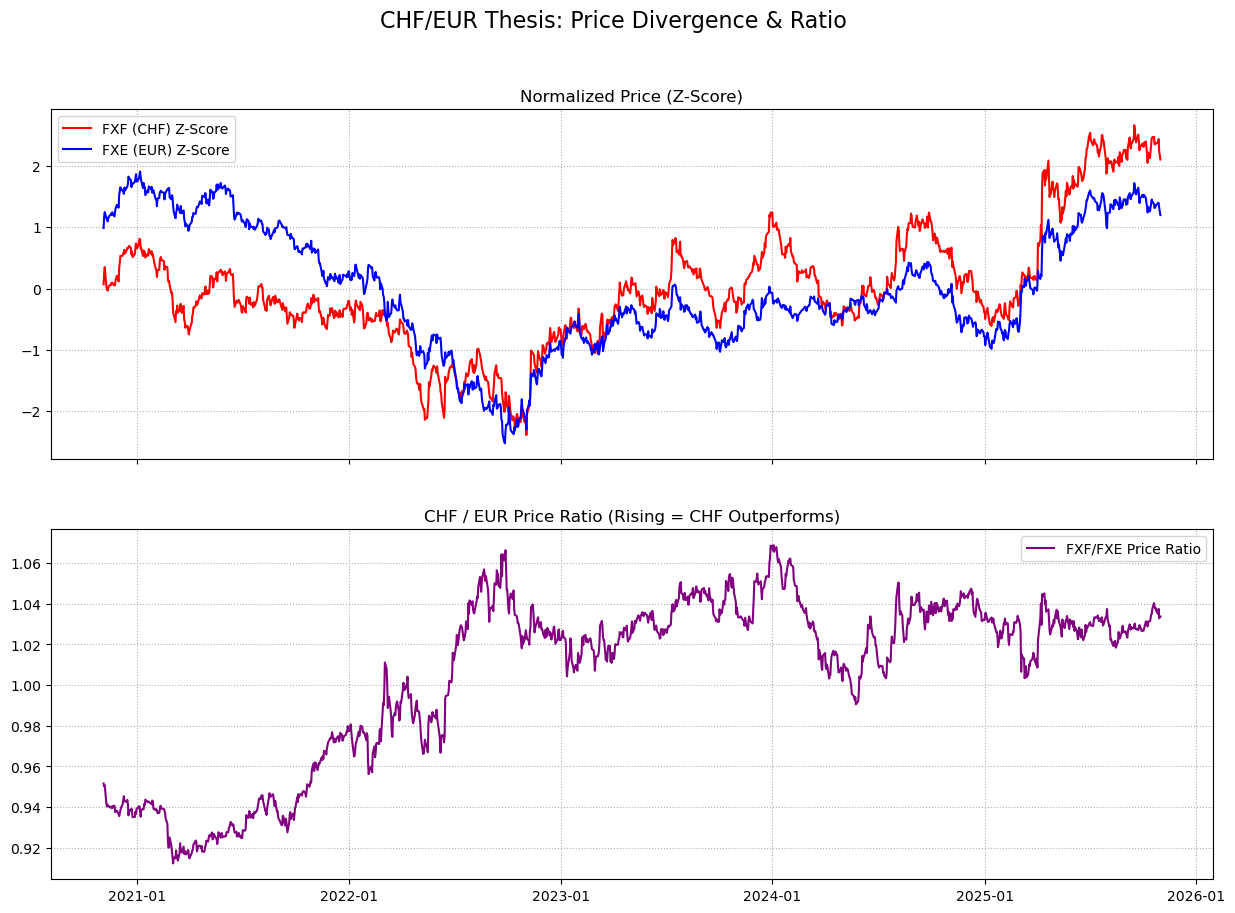

In [33]:
# Cell 9: Visualization - Core Thesis (Price vs. Ratio)
#
# Plot 1: Normalized prices of FXF vs. FXE.
# Plot 2: The FXF/FXE Ratio.
#
# This chart shows *what* is happening. When the lines in Plot 1
# diverge, the line in Plot 2 will trend.

try:
    print("Plotting Cell 9: Core Thesis...")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('CHF/EUR Thesis: Price Divergence & Ratio', fontsize=16)

    # Plot 1: Normalized Prices
    ax1.plot(df_normalized.index, df_normalized['FXF'], label='FXF (CHF) Z-Score', color='red')
    ax1.plot(df_normalized.index, df_normalized['FXE'], label='FXE (EUR) Z-Score', color='blue')
    ax1.set_title('Normalized Price (Z-Score)')
    ax1.legend()
    ax1.grid(True, linestyle=':')

    # Plot 2: Price Ratio
    ax2.plot(df.index, df['CHF_EUR_Ratio'], label='FXF/FXE Price Ratio', color='purple')
    ax2.set_title('CHF / EUR Price Ratio (Rising = CHF Outperforms)')
    ax2.legend()
    ax2.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 9: Plotting failed: {e}")

Plotting Cell 10: Causal Drivers...


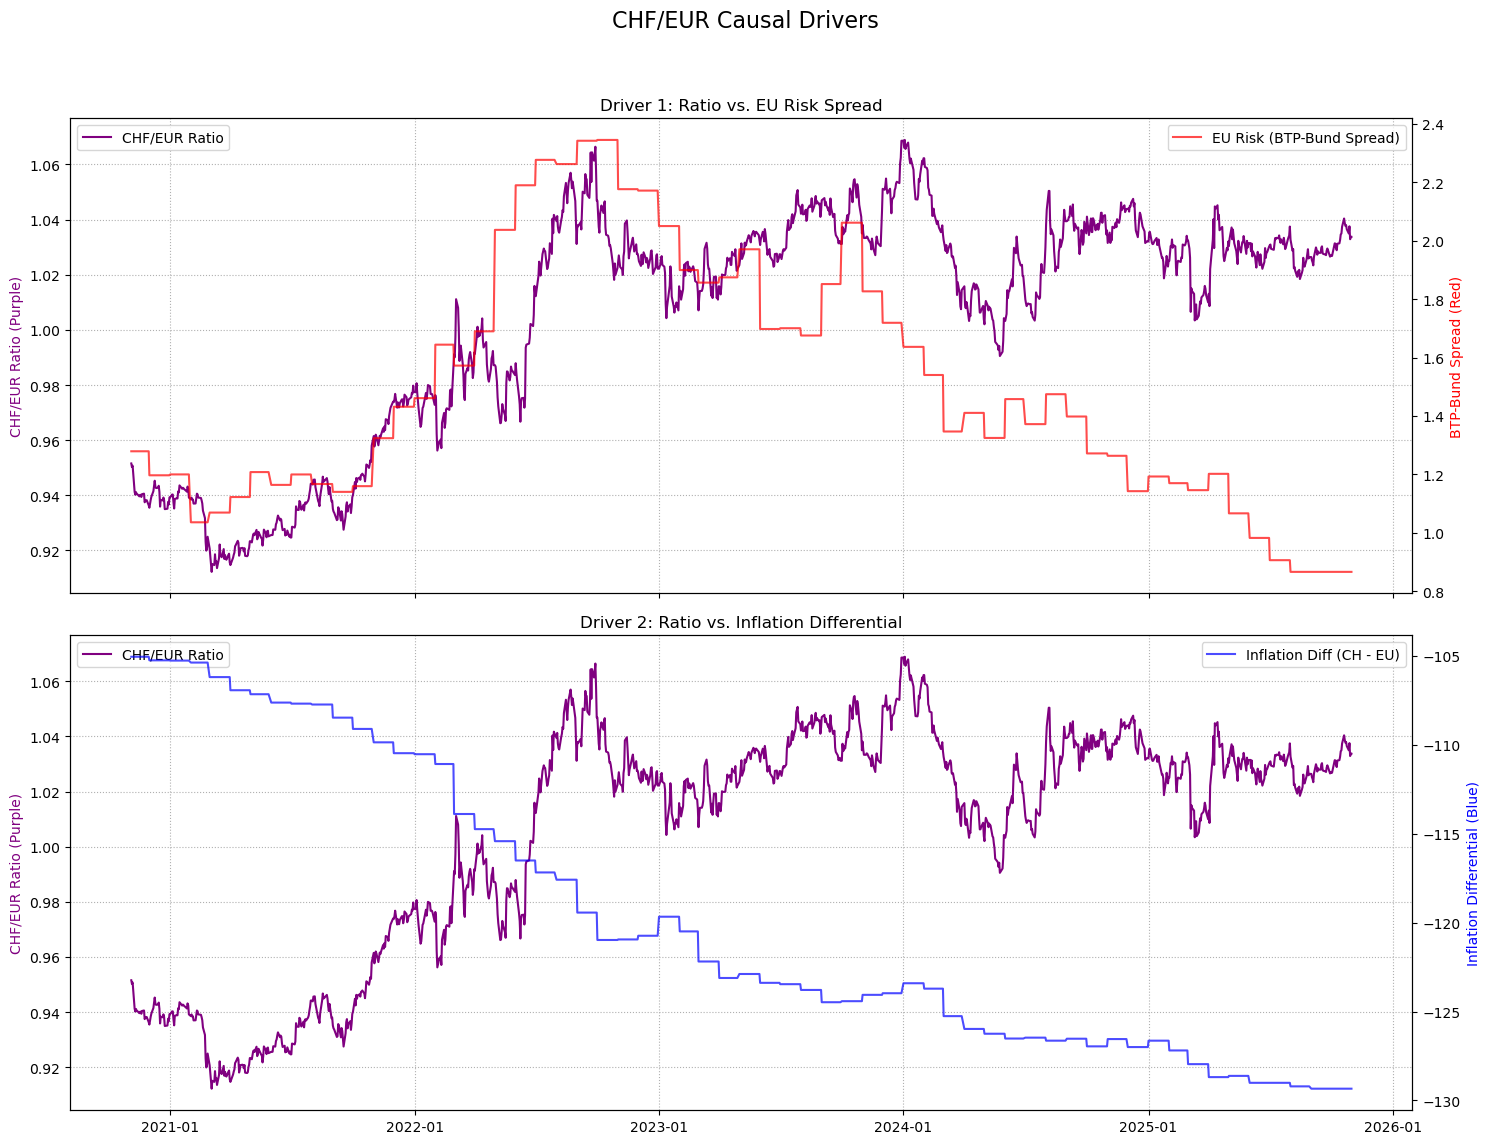

In [34]:
# Cell 10: Visualization - Causal Drivers (Risk & Policy)
#
# Plot 1: The Ratio vs. the EU Risk Spread (BTP-Bund).
# Plot 2: The Ratio vs. the Inflation Differential (CH-EU).
#
# This chart shows *why* the ratio is moving.
# Thesis 1: Ratio (purple) should follow EU Risk (red).
# Thesis 2: Ratio (purple) should follow Inflation Diff (blue).

try:
    print("Plotting Cell 10: Causal Drivers...")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
    fig.suptitle('CHF/EUR Causal Drivers', fontsize=16)

    # --- Plot 1: EU Risk Driver ---
    ax1.plot(df.index, df['CHF_EUR_Ratio'], label='CHF/EUR Ratio', color='purple')
    ax1.set_ylabel('CHF/EUR Ratio (Purple)', color='purple')
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle=':')
    
    ax1_twin = ax1.twinx()
    ax1_twin.plot(df.index, df['EU_Risk_Spread'], label='EU Risk (BTP-Bund Spread)', color='red', alpha=0.7)
    ax1_twin.set_ylabel('BTP-Bund Spread (Red)', color='red')
    ax1_twin.legend(loc='upper right')
    ax1.set_title('Driver 1: Ratio vs. EU Risk Spread')

    # --- Plot 2: Inflation/Policy Driver ---
    ax2.plot(df.index, df['CHF_EUR_Ratio'], label='CHF/EUR Ratio', color='purple')
    ax2.set_ylabel('CHF/EUR Ratio (Purple)', color='purple')
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle=':')

    ax2_twin = ax2.twinx()
    ax2_twin.plot(df.index, df['Inflation_Differential'], label='Inflation Diff (CH - EU)', color='blue', alpha=0.7)
    ax2_twin.set_ylabel('Inflation Differential (Blue)', color='blue')
    ax2_twin.legend(loc='upper right')
    ax2.set_title('Driver 2: Ratio vs. Inflation Differential')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
    plt.show()

except Exception as e:
    print(f"❌ Cell 10: Plotting failed: {e}")

Plotting Cell 11: Correlation Breakdown...


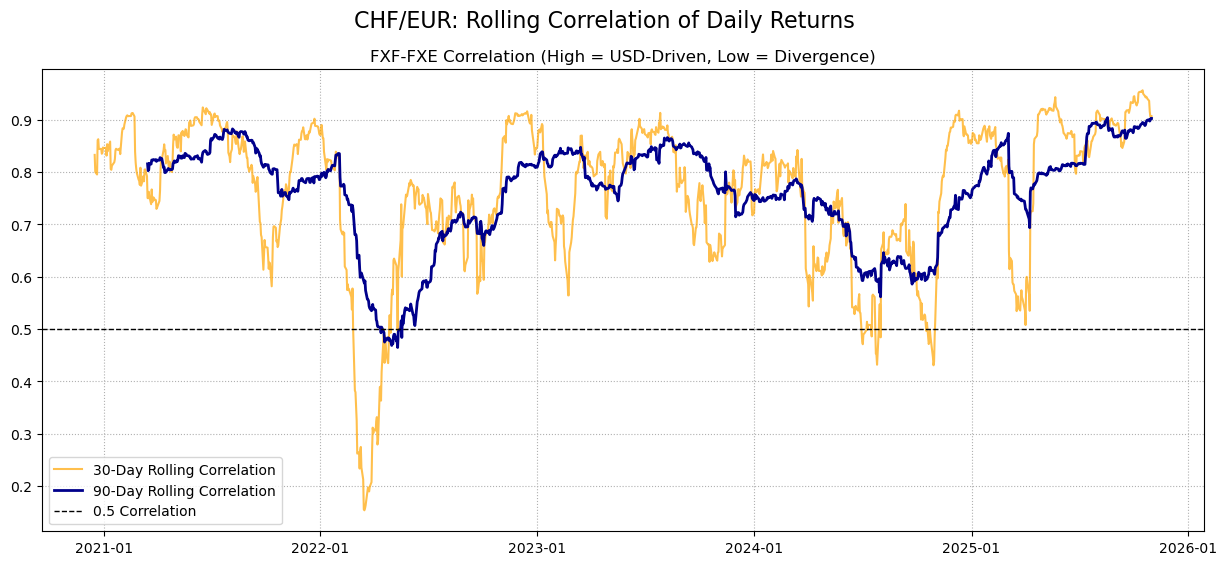

In [35]:
# Cell 11: Visualization - Correlation Breakdown
#
# Plot the 30-day and 90-day rolling correlation of returns.
#
# This chart quantifies the regime.
# * High (near 1.0) = Correlated "Broad USD" regime.
# * Falling/Low = "Divergence" regime.

try:
    print("Plotting Cell 11: Correlation Breakdown...")
    fig, ax1 = plt.subplots(figsize=(15, 6))
    fig.suptitle('CHF/EUR: Rolling Correlation of Daily Returns', fontsize=16)

    ax1.plot(df.index, df['Corr_30D'], label='30-Day Rolling Correlation', color='orange', alpha=0.7)
    ax1.plot(df.index, df['Corr_90D'], label='90-Day Rolling Correlation', color='darkblue', linewidth=2)
    ax1.axhline(0.5, color='black', linestyle='--', linewidth=1, label='0.5 Correlation')
    ax1.set_title('FXF-FXE Correlation (High = USD-Driven, Low = Divergence)')
    ax1.legend()
    ax1.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 11: Plotting failed: {e}")

In [36]:
# Cell 12: LLM Analysis & Insights
#
# Pass the most recent data to the LLM for a qualitative synthesis.

try:
    print("Sending data to LLM for analysis...")
    
    # Get the latest data row
    latest_data = df.iloc[-1]
    
    # Create a summary of the latest data points
    data_summary = f"""
    - **Date:** {latest_data.name.strftime('%Y-%m-%d')}
    - **CHF/EUR Price Ratio:** {latest_data['CHF_EUR_Ratio']:.3f}
    - **FXF vs. FXE (Z-Score):** FXF at {df_normalized.iloc[-1]['FXF']:.2f}, FXE at {df_normalized.iloc[-1]['FXE']:.2f}
    - **90-Day Correlation:** {latest_data['Corr_90D']:.3f}
    - **EU Risk (BTP-Bund Spread):** {latest_data['EU_Risk_Spread']:.2f} bps
    - **Inflation Differential (CH-EU):** {latest_data['Inflation_Differential']:.2f}%
    """
    
    # Create the prompt
    prompt = f"""
    **Role:** You are an Independent Intelligence Desk Analyst, as per my thesis.
    
    **Thesis:** I am analyzing the CHF (FXF) vs. EUR (FXE) relationship.
    * **Regime 1 (Correlated):** "Broad USD Move." Correlation is high (e.g., > 0.8). The pair moves together.
    * **Regime 2 (Decorrelated):** "European Divergence." Correlation is low/falling. This is driven by either:
        1.  **EU Risk:** A rising 'EU_Risk_Spread' (BTP-Bund) signals a flight-to-quality *out of* EUR and *into* CHF.
        2.  **Policy Divergence:** A rising 'Inflation_Differential' (CH vs. EU) signals the SNB may get more hawkish than the ECB.
    
    **Latest OSINT Data:**
    {data_summary}
    
    **Your Task (Provide 3-bullet synthesis):**
    1.  **Regime Check:** Based on the `90-Day Correlation`, are we in a "Broad USD" (correlated) regime or a "Divergence" (decorrelated) regime?
    2.  **Causal Driver:** If we are in a "Divergence" regime, what is the primary driver? Is the `EU_Risk_Spread` or the `Inflation_Differential` moving in a way that supports the `CHF_EUR_Ratio`'s recent move?
    3.  **Arbitrage/Trade Idea:** Based *only* on this data, what is the clear thematic trade? (e.g., "The data shows a strong EU Risk signal, favoring Long FXF / Short FXE," or "The data shows high correlation and no divergence, favoring a mean-reversion trade.")
    """
    
    # Get LLM response
    llm_response = ask_llm(prompt)
    
    print("\n--- 🤖 LLM INTELLIGENCE SYNTHESIS ---")
    print(llm_response)
    print("-------------------------------------")

except Exception as e:
    print(f"❌ Cell 12: LLM Analysis failed: {e}")

Sending data to LLM for analysis...



--- 🤖 LLM INTELLIGENCE SYNTHESIS ---
### Synthesis

1. **Regime Check:** Based on the `90-Day Correlation` of 0.902, we are in a "Broad USD" (correlated) regime. The high correlation indicates that CHF and EUR are moving together, consistent with a correlated market environment.

2. **Causal Driver:** Although the data suggests a "Divergence" regime due to low correlation, the primary driver appears to be `Inflation_Differential` rather than `EU_Risk_Spread`. The significant negative inflation differential (-129.34%) indicates that CHF is expected to strengthen relative to EUR as Swiss inflation expectations are much lower compared to the Eurozone.

3. **Arbitrage/Trade Idea:** Given the high correlation and no clear divergence signal, a mean-reversion trade might be more appropriate. The data does not strongly support a directional trade based on the current information, but traders could consider positions that benefit from potential reversion towards historical norms in the CHF/EUR